# Feature Engineering

In [1]:
import os
import sys
import pandas as pd 
import datetime 
import math 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab

%load_ext autoreload
%autoreload 2
%matplotlib inline 

# Setting up directories
ROOT_DIR = os.path.join(os.getcwd(), '..')
# ROOT_DIR =os.getcwd()

SRC_DIR = os.path.join(os.getcwd(), '..', 'src')
DATA_DIR = os.path.join(ROOT_DIR, "data")
RAW_DATA_DIR = os.path.join(DATA_DIR, "01_raw")

sys.path.append(ROOT_DIR)
sys.path.append(SRC_DIR)
os.chdir(ROOT_DIR)

### Load Data

In [2]:
cust_seg_df_raw = pd.read_excel(os.path.join(RAW_DATA_DIR, "Online Retail.xlsx"))

In [3]:
cust_seg_df = cust_seg_df_raw.copy()

### Separate data for UK

As 91% orders are within Uk. which is a largest segment by country. I will focus on that.

In [4]:
cust_seg_df = cust_seg_df[cust_seg_df['Country'] == 'United Kingdom']

### Attribute for total amount

In [5]:
cust_seg_df['Amount'] = cust_seg_df['Quantity'] * cust_seg_df['UnitPrice']

### Remove missing customerID records

In [6]:
cust_seg_df = cust_seg_df[cust_seg_df['CustomerID'].notnull()]

### Eliminate return (negative) transactions

In [7]:
cust_seg_df = cust_seg_df[cust_seg_df['Amount'] >= 0 ]

In [8]:
# Modified data look
cust_seg_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Create Recency Feature Variable - Days since last purchase

Reference Date: one day after the last transaction <br>
Recency Variable: Number of days before the reference date when a customer last made a purchase.

##### Refernce Date:

In [9]:
last_date =  cust_seg_df['InvoiceDate'].max()
reference_date =  last_date  +   datetime.timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:49:00')

##### Recency Period - by transaction:

In [10]:
cust_seg_df['RecencyPeriod'] = reference_date - cust_seg_df['InvoiceDate']

# Get number only of days
cust_seg_df['RecencyPeriod'] = cust_seg_df['RecencyPeriod'].astype('timedelta64[D]') 

### Customer History
##### Recency Period - by customer 
Becuase receny is customer based (not order/transaction based)

In [11]:
# Groub by minimum Recency Period as it the lastest one
customer_history = cust_seg_df.groupby('CustomerID')['RecencyPeriod'].min()\
.reset_index()[['CustomerID', 'RecencyPeriod']]
print(customer_history.head())

# Getting Description of RecencyPeriod
customer_history['RecencyPeriod'].describe()

   CustomerID  RecencyPeriod
0     12346.0          326.0
1     12747.0            2.0
2     12748.0            1.0
3     12749.0            4.0
4     12820.0            3.0


count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: RecencyPeriod, dtype: float64

### Examin distribution of Recency Period of customers

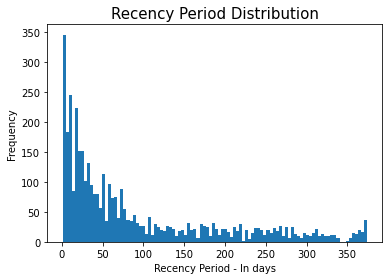

In [12]:
plt.hist(customer_history['RecencyPeriod'], bins=100)

plt.title("Recency Period Distribution", size=15)
plt.xlabel("Recency Period - In days")
plt.ylabel("Frequency")

plt.show()

### Create Monetary Feature Variable

In [13]:
customer_monetary_val = cust_seg_df[['CustomerID', 'Amount']].groupby("CustomerID").sum().reset_index()
customer_history = customer_history.merge(customer_monetary_val, how='outer')

# Adding small amount of 0.001  # As I look forward to do log scale transformation and having zero could cause an error
customer_history['Amount'] = customer_history['Amount'] + 0.001

In [14]:
customer_history.head()

,CustomerID,RecencyPeriod,Amount
0,12346.0,326.0,77183.601
1,12747.0,2.0,4196.011
2,12748.0,1.0,33719.731
3,12749.0,4.0,4090.881
4,12820.0,3.0,942.341


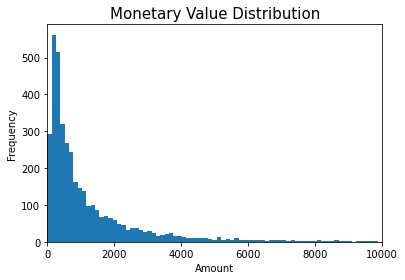

In [15]:
plt.hist(customer_history['Amount'], bins=2000)

plt.title("Monetary Value Distribution", size=15)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0,10000)

plt.show()

### Crearing Frequency Feature Variable

In [16]:
customer_freq = cust_seg_df[['CustomerID', 'Amount']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'Amount':'Frequency'},inplace=True)

customer_history = customer_history.merge(customer_freq, how='outer')

In [17]:
customer_history.head()

,CustomerID,RecencyPeriod,Amount,Frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


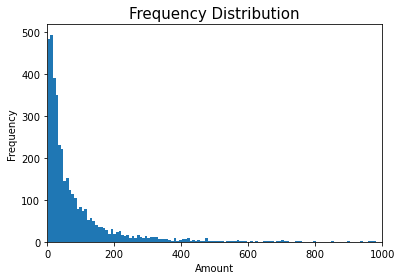

In [18]:
plt.hist(customer_history['Frequency'], bins=1000)

plt.title("Frequency Distribution", size=15)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0,1000)

plt.show()

# Data Preprocessing

In [20]:
from sklearn.preprocessing import StandardScaler
import math

In [21]:
### log Transformation 
customer_history['Recency_log'] = customer_history['RecencyPeriod'].apply(math.log)
customer_history['Frequency_log'] = customer_history['Frequency'].apply(math.log)
customer_history['Amount_log'] = customer_history['Amount'].apply(math.log)

In [22]:
customer_history.head()

,CustomerID,RecencyPeriod,Amount,Frequency,Recency_log,Frequency_log,Amount_log
0,12346.0,326.0,77183.601,1,5.786897,0.000000,11.253942
1,12747.0,2.0,4196.011,103,0.693147,4.634729,8.341890
2,12748.0,1.0,33719.731,4596,0.000000,8.432942,10.425838
3,12749.0,4.0,4090.881,199,1.386294,5.293305,8.316516
4,12820.0,3.0,942.341,59,1.098612,4.077537,6.848367


### Feature Scaling

In [23]:
# Feature tht would be scaled
features_list = ['Amount_log', 'Recency_log', 'Frequency_log']
customer_history_to_scaled = customer_history[features_list]

# Scaling
# customer_history_scaled is a view of customer_history dataframe
# Hence, all changes are automatically done in customer_history df
scaler = StandardScaler()
scaler.fit(customer_history_to_scaled)
customer_history_scaled = scaler.transform(customer_history_to_scaled)

In [24]:
customer_history.head()

,CustomerID,RecencyPeriod,Amount,Frequency,Recency_log,Frequency_log,Amount_log
0,12346.0,326.0,77183.601,1,5.786897,0.000000,11.253942
1,12747.0,2.0,4196.011,103,0.693147,4.634729,8.341890
2,12748.0,1.0,33719.731,4596,0.000000,8.432942,10.425838
3,12749.0,4.0,4090.881,199,1.386294,5.293305,8.316516
4,12820.0,3.0,942.341,59,1.098612,4.077537,6.848367


### Visualizing Recency vs Monetary Value (scaled)

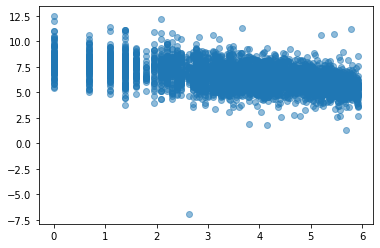

In [25]:
plt.scatter(customer_history['Recency_log'], customer_history['Amount_log'], alpha=0.5)
plt.show()

### Visualizing Monetary Value distribution (scaled)¶


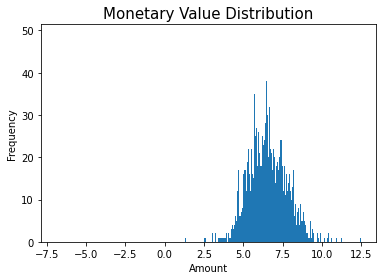

In [26]:
plt.hist(customer_history['Amount_log'], bins=1000)

plt.title("Monetary Value Distribution", size=15)
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.show()

### Visualizing Monetary Value, Frequency and Rececny (scaled)¶


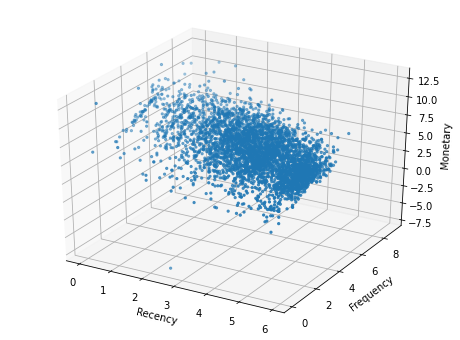

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history['Recency_log']
ys = customer_history['Frequency_log']
zs = customer_history['Amount_log']
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

It seems people with less rececney but high freqency spend more.


# Modeling - Clustering

### K-Mean Clustering

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

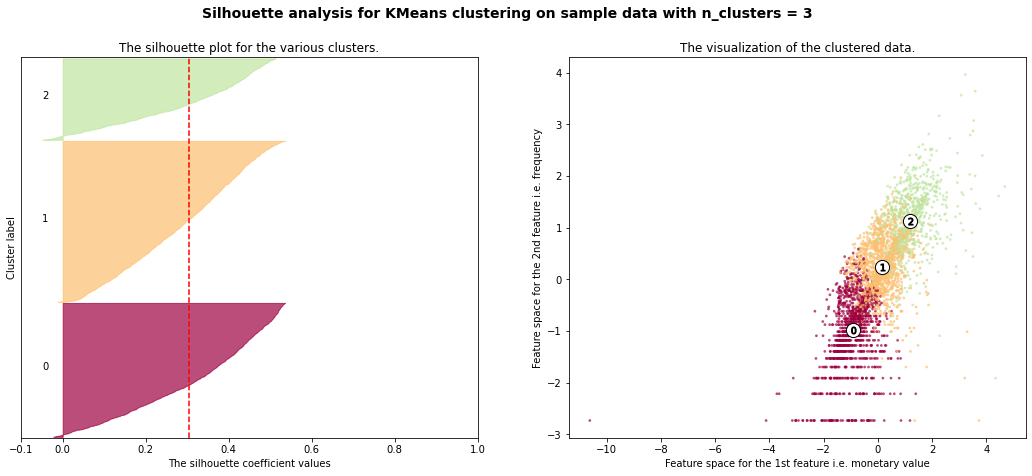

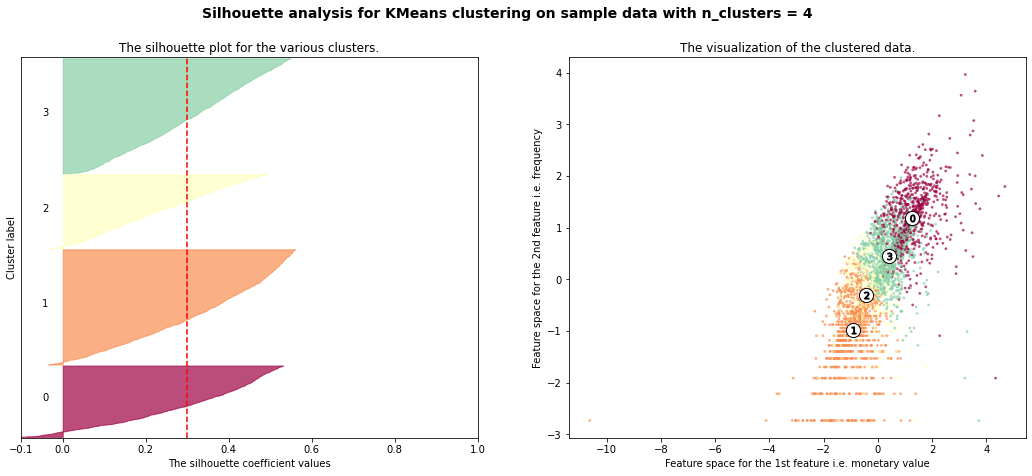

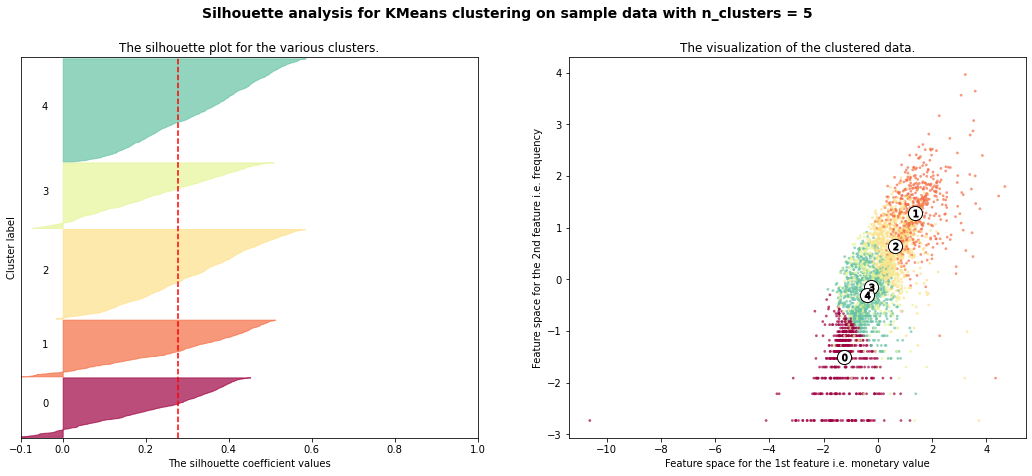

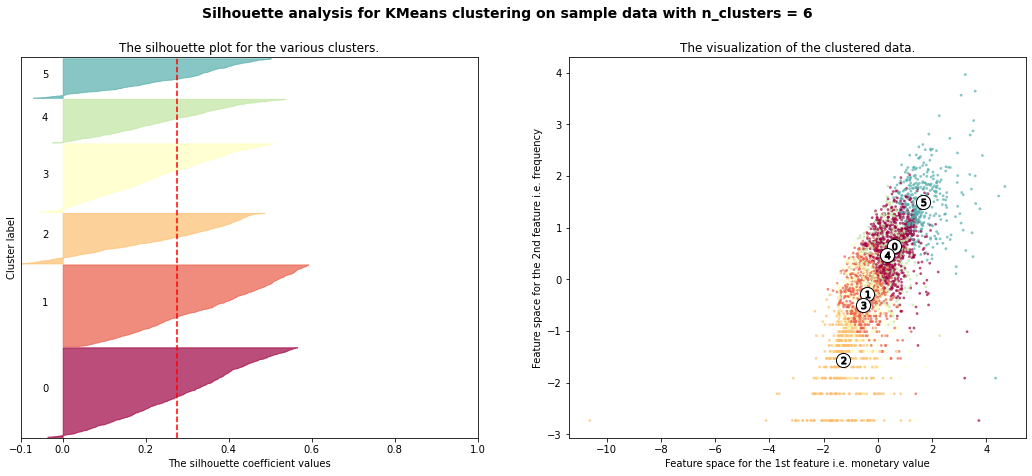

In [29]:
X = customer_history_scaled

cluster_centers = dict()

range_n_clusters = [3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    plt.show()

### Cluster Analysis
Retranforming Clusters center values to normal values for further analysis

In [30]:
range_n_clusters = [3, 4, 5, 6]
features_list = ['Amount_log', 'Recency_log', 'Frequency_log']

for i in range_n_clusters:
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features_list))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
    Amount_log  Recency_log  Frequency_log
0   220.198311   122.258999      10.545038
1   828.741744    44.343353      53.275214
2  3158.748880     7.396805     177.087308
Silhouette score for cluster 3 is 0.30344910866275493

for 4 number of clusters
    Amount_log  Recency_log  Frequency_log
0  3424.350025     6.609169     191.371477
1   220.828630   158.712260      10.414508
2   404.107709    17.899753      25.787074
3  1146.981946    65.376524      71.138548
Silhouette score for cluster 4 is 0.29853541748148454

for 5 number of clusters
    Amount_log  Recency_log  Frequency_log
0   144.581761   121.494119       5.203414
1  3983.000207     5.669752     216.919083
2  1529.103414    48.475555      93.359920
3   491.225157    13.227883      31.937363
4   407.421058   138.857191      25.576757
Silhouette score for cluster 5 is 0.2782580724931221

for 6 number of clusters
    Amount_log  Recency_log  Frequency_log
0  1493.572685    49.613000      91.438288
1   4

### Clusters Labels Assignment

In [44]:
labels = cluster_centers[3]['labels']
customer_history['num_cluster3_labels'] = labels
labels = cluster_centers[4]['labels']
customer_history['num_cluster4_labels'] = labels
labels = cluster_centers[5]['labels']   
customer_history['num_cluster5_labels'] = labels
labels = cluster_centers[6]['labels']
customer_history['num_cluster6_labels'] = labels


### Visualization

In [49]:
amount_cutoff = np.percentile(customer_history['Amount'], 80)
customer_history_amt_80th_percent = customer_history[customer_history['Amount'] <= amount_cutoff]

In [92]:
def plot_boxen(feature):
    ranks = customer_history_amt_80th_percent.groupby(feature)["Amount"].mean().sort_values().index
    sns.boxenplot(x=feature, y="Amount", data=customer_history_amt_80th_percent, palette="Set3", order=ranks)
    plt.show()

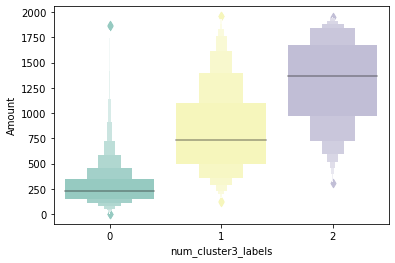

In [93]:
plot_boxen('num_cluster3_labels')

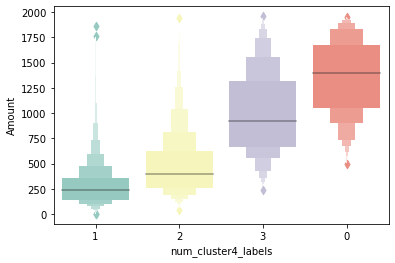

In [94]:
plot_boxen('num_cluster4_labels')

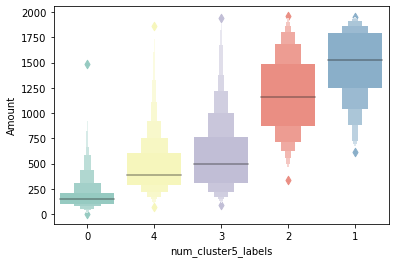

In [95]:
plot_boxen('num_cluster5_labels')

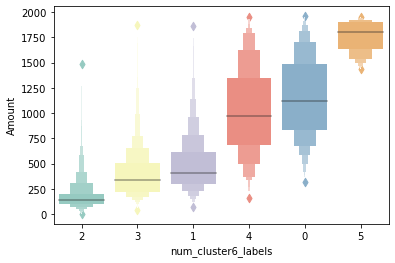

In [96]:
plot_boxen('num_cluster6_labels')